In [71]:
import os
from random import sample, shuffle
from functools import partial
import re

from matplotlib import pyplot as plt
import pandas as pd
from PIL import Image
import torch
import albumentations as A
from tqdm import tqdm
import numpy as np

from torch.utils.data import Dataset, DataLoader
from PIL import Image

import timm
from transformers import AutoModelForCausalLM
from transformers import AutoModel, AutoTokenizer

import torch
import torch.nn as nn
import torchvision.transforms as T
from torchmetrics import MeanAbsoluteError, MeanAbsolutePercentageError, MeanSquaredError

from sklearn.model_selection import train_test_split

from src.constants import DATA_PATH
from src.dataset import MultimodalDataset, collate_fn, get_transforms
from src.utils import MultimodalModel, seed_everything, train, validate

In [2]:
%load_ext autoreload
%autoreload 2

# 1. EDA

## 1.1 Загрузка данных

In [3]:
dish_path = f'{DATA_PATH}dish.csv'
ingredients_path = f'{DATA_PATH}ingredients.csv'

In [4]:
df_dish = pd.read_csv(dish_path)
df_ing = pd.read_csv(ingredients_path)

In [5]:
df_ing

,id,ingr
0,1,cottage cheese
1,2,strawberries
2,3,garden salad
3,4,bacon
4,5,potatoes
...,...,...
550,551,pizza sauce
551,552,pomegranate
552,553,nut cheese
553,554,soy sausage


In [6]:
df_dish

,dish_id,total_calories,total_mass,ingredients,split
0,dish_1561662216,300.794281,193.0,ingr_0000000508;ingr_0000000122;ingr_000000002...,test
1,dish_1561662054,419.438782,292.0,ingr_0000000312;ingr_0000000026;ingr_000000002...,train
2,dish_1562008979,382.936646,290.0,ingr_0000000448;ingr_0000000520;ingr_000000046...,test
3,dish_1560455030,20.590000,103.0,ingr_0000000471;ingr_0000000031;ingr_0000000347,train
4,dish_1558372433,74.360001,143.0,ingr_0000000453,train
...,...,...,...,...,...
3257,dish_1563295334,228.540009,96.0,ingr_0000000004;ingr_0000000008,train
3258,dish_1566329234,262.625214,457.0,ingr_0000000161;ingr_0000000189;ingr_000000000...,train
3259,dish_1562691737,485.676880,700.0,ingr_0000000543;ingr_0000000027;ingr_000000012...,train
3260,dish_1558458496,53.130001,77.0,ingr_0000000440,train


<Axes: >

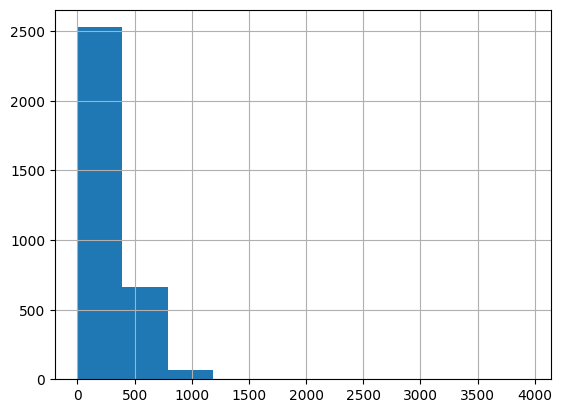

In [7]:
df_dish['total_calories'].hist()

<Axes: >

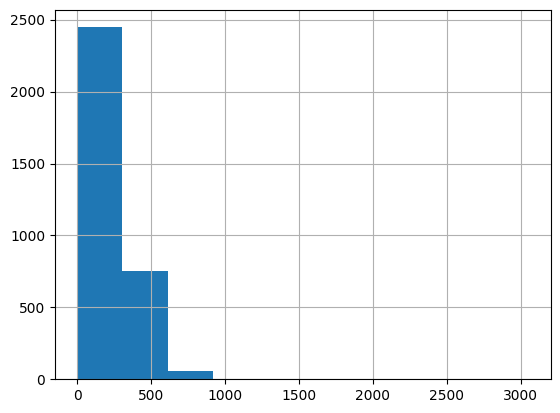

In [8]:
df_dish['total_mass'].hist()

In [9]:
image_paths= [f'{DATA_PATH}images/{p}/rgb.png' for p in os.listdir(f'{DATA_PATH}images/')]

In [10]:
image_paths[:4]

['data/images/dish_1564515049/rgb.png',
 'data/images/dish_1566328894/rgb.png',
 'data/images/dish_1562698209/rgb.png',
 'data/images/dish_1562788732/rgb.png']

In [11]:
def plot_sample_images(image_paths):
    _, axs = plt.subplots(3, 3, figsize=(5, 5))
    axs = axs.flatten()
    image_paths_sample = sample(image_paths, 9)
    imgs = [Image.open(img_path).convert('RGB') for img_path in image_paths_sample]
    for img, ax in zip(imgs, axs):
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(img)

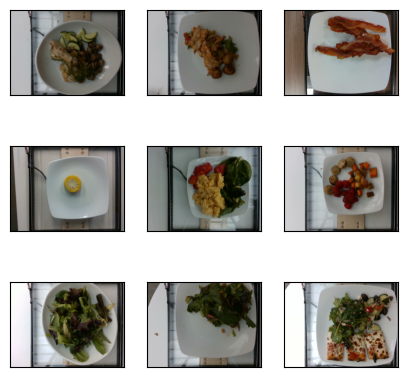

In [12]:
plot_sample_images(image_paths)

In [110]:
def plot_images_flatten(image_paths, sample_flg=True, sample_count=5, figsize=(8, 8),):
    if sample_flg:
        _, axs = plt.subplots(1, sample_count, figsize=figsize)
        image_paths_sample = sample(image_paths, sample_count)
    else:
        _, axs = plt.subplots(1, len(image_paths), figsize=figsize)
        image_paths_sample = image_paths
    axs = axs.flatten()    
    imgs = [Image.open(img_path).convert('RGB') for img_path in image_paths_sample]
    for img, ax in zip(imgs, axs):
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(img)

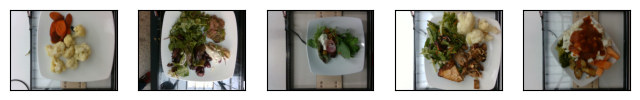

In [113]:
plot_images_flatten(image_paths)

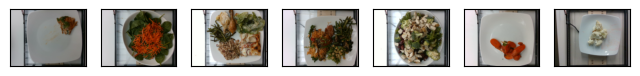

In [117]:
plot_images_flatten(image_paths[3:10], sample_flg=False)

## 1.2 Обработка текстового описания - переход к токенам

In [13]:
dict_ingredients = {k:v for k, v in zip(df_ing['id'], df_ing['ingr'])}
dict_ingredients

{1: 'cottage cheese',
 2: 'strawberries',
 3: 'garden salad',
 4: 'bacon',
 5: 'potatoes',
 6: 'caesar salad',
 7: 'cauliflower',
 8: 'scrambled eggs',
 9: 'wild rice',
 10: 'steak',
 11: 'cheese pizza',
 12: 'olives',
 13: 'berries',
 14: 'asparagus',
 15: 'hash browns',
 16: 'brussels sprouts',
 17: 'pasta salad',
 18: 'turkey',
 19: 'bread',
 20: 'duck',
 21: 'squash',
 22: 'guacamole',
 23: 'brown rice',
 24: 'artic char',
 25: 'beef',
 26: 'white rice',
 27: 'broccoli',
 28: 'chicken',
 29: 'mixed greens',
 30: 'lettuce',
 31: 'cucumbers',
 32: 'tomatoes',
 33: 'bell peppers',
 34: 'celery',
 35: 'blue cheese',
 36: 'spinach (raw)',
 37: 'cantaloupe',
 38: 'pineapple',
 39: 'sausage',
 40: 'raspberries',
 41: 'blackberries',
 42: 'avocado',
 43: 'green beans',
 44: 'bean sprouts',
 45: 'carrot',
 46: 'mushroom',
 47: 'corn',
 48: 'ham',
 49: 'fish',
 50: 'tofu',
 51: 'shrimp',
 52: 'cheese',
 53: 'nuts',
 54: 'apple',
 55: 'banana',
 56: 'kiwi',
 57: 'lemon',
 58: 'orange',
 59: '

In [14]:
# def parse_ingredients(raw_text, dict_ingredients):
#     return ' '.join([dict_ingredients[int(t[12:])] for t in raw_text.split(';')])

def get_ingredients_idx(raw_text):
    return [int(t[12:]) for t in raw_text.split(';')]

In [15]:
df_dish['ingredients_idx'] = df_dish['ingredients'].apply(lambda x: get_ingredients_idx(x))

In [16]:
df_dish.head()

,dish_id,total_calories,total_mass,ingredients,split,ingredients_idx
0,dish_1561662216,300.794281,193.0,ingr_0000000508;ingr_0000000122;ingr_000000002...,test,"[508, 122, 26, 524, 94, 23, 189, 54, 29, 328, ..."
1,dish_1561662054,419.438782,292.0,ingr_0000000312;ingr_0000000026;ingr_000000002...,train,"[312, 26, 29, 122, 508, 513, 520, 525, 161, 94..."
2,dish_1562008979,382.936646,290.0,ingr_0000000448;ingr_0000000520;ingr_000000046...,test,"[448, 520, 462, 514, 152, 312, 291, 45, 122, 6..."
3,dish_1560455030,20.590000,103.0,ingr_0000000471;ingr_0000000031;ingr_0000000347,train,"[471, 31, 347]"
4,dish_1558372433,74.360001,143.0,ingr_0000000453,train,[453]


## 1.3 Выделение валидационного сета

In [17]:
df_test = df_dish[df_dish['split'] == 'test'].reset_index(drop=True)

In [18]:
df_train = df_dish[df_dish['split'] == 'train'].reset_index(drop=True)

In [19]:
# df_train, df_valid = train_test_split(df_dish[df_dish['split'] == 'train'], 
#                                       test_size=0.15,)
# df_train.reset_index(drop=True, inplace=True)
# df_valid.reset_index(drop=True, inplace=True)

## 1.1 
- Как решать задачу: Мультимодальная нейросеть. Картинка + текст + масса блюда
- Аугментация/обогащение. Тексты: аугментация за счет перестановки токенов. Изображение: стандартные методы аугментации изображений
- Метрики -  MAE, RMSE, MAPE

# Этап 2. Реализуйте пайплайн обучения

## 2.1 Загрузчики данных и датасеты

## 2.2 Опциональный код предобработки/аугментации данных

## 2.3 Код обучения и валидации для импортирования в виде одной функции

###  А ТЕПЕРЬ ОБУЧЕНИЕ и ВАЛИДАЦИЯ

## 2.4 Конфиг-файл для запуска модели и сохранения результатов обучения

In [24]:
class Config:
    SEED = 42

    TEXT_MODEL_NAME = "bert-base-uncased"
    IMAGE_MODEL_NAME = "tf_efficientnet_b0"

    TEXT_MODEL_UNFREEZE = "encoder.layer.11|pooler"
    IMAGE_MODEL_UNFREEZE = "blocks.6|conv_head|bn2"

    BATCH_SIZE = 16 #256
    TEXT_LR = 3e-5
    IMAGE_LR = 1e-4
    REGRESSOR_LR = 1e-3
    EPOCHS = 2 #30
    DROPOUT = 0.2
    HIDDEN_DIM = 256

    # Пути
    # TRAIN_DF_PATH = f"{ROOT_PATH}data/imdb_train.csv"
    # VAL_DF_PATH = f"{ROOT_PATH}data/imdb_val.csv"
    SAVE_PATH = "models/best_model.pth"

In [30]:
config = Config()
device = "cuda" if torch.cuda.is_available() else "cpu"
seed_everything(config.SEED)

In [31]:
device

'cuda'

## 2.5 Код для получения воспроизводимых результатов (seed) с выводом метрик

# Этап 3. Обучение модели

## 3.1 Вызов метода обучения с передачей конфига

In [27]:
train(config, device)

Разморожен слой: encoder.layer.11.attention.self.query.weight
Разморожен слой: encoder.layer.11.attention.self.query.bias
Разморожен слой: encoder.layer.11.attention.self.key.weight
Разморожен слой: encoder.layer.11.attention.self.key.bias
Разморожен слой: encoder.layer.11.attention.self.value.weight
Разморожен слой: encoder.layer.11.attention.self.value.bias
Разморожен слой: encoder.layer.11.attention.output.dense.weight
Разморожен слой: encoder.layer.11.attention.output.dense.bias
Разморожен слой: encoder.layer.11.attention.output.LayerNorm.weight
Разморожен слой: encoder.layer.11.attention.output.LayerNorm.bias
Разморожен слой: encoder.layer.11.intermediate.dense.weight
Разморожен слой: encoder.layer.11.intermediate.dense.bias
Разморожен слой: encoder.layer.11.output.dense.weight
Разморожен слой: encoder.layer.11.output.dense.bias
Разморожен слой: encoder.layer.11.output.LayerNorm.weight
Разморожен слой: encoder.layer.11.output.LayerNorm.bias
Разморожен слой: pooler.dense.weight
Раз

  0%|          | 0/204 [00:00<?, ?it/s]/home/russele7/practicum/dle/sprint_4/practicum_dle_sprint_4/src/utils.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mass_features = torch.tensor(mass_input).unsqueeze(1)
100%|██████████| 204/204 [02:26<00:00,  1.40it/s]


Epoch 0/1 | avg_Loss: 232.5757 | Train MAE: 232.5944| Val MAE: 211.5939
New best model, epoch: 0
epoch 1


100%|██████████| 204/204 [02:24<00:00,  1.42it/s]


Epoch 1/1 | avg_Loss: 187.9404 | Train MAE: 187.9076| Val MAE: 162.9883


# Этап 4. Валидация

## 4.1 Расчет целевой метрики на тестовом датасете

In [42]:
model = MultimodalModel(config)

In [43]:
model.load_state_dict(torch.load(config.SAVE_PATH))

<All keys matched successfully>

In [45]:
model = model.to(device)

In [46]:
type(model)

src.utils.MultimodalModel

In [47]:
tokenizer = AutoTokenizer.from_pretrained(config.TEXT_MODEL_NAME)

In [48]:
val_transforms = get_transforms(config, mode="test")

In [49]:
val_dataset = MultimodalDataset(config, val_transforms, mode="test")

In [50]:
val_loader = DataLoader(val_dataset,
                        batch_size=config.BATCH_SIZE,
                        shuffle=False,
                        collate_fn=partial(collate_fn,
                        tokenizer=tokenizer,
                        mode="test"))

In [57]:
mae_valid = validate(model, val_loader, device, MeanAbsoluteError().to(device))

In [58]:
mape_valid = validate(model, val_loader, device, MeanAbsolutePercentageError().to(device))

  0%|          | 0/204 [00:00<?, ?it/s]/home/russele7/practicum/dle/sprint_4/practicum_dle_sprint_4/src/utils.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mass_features = torch.tensor(mass_input).unsqueeze(1)
100%|██████████| 204/204 [01:30<00:00,  2.26it/s]


In [62]:
mse_valid = validate(model, val_loader, device, MeanSquaredError().to(device))

  0%|          | 0/204 [00:00<?, ?it/s]/home/russele7/practicum/dle/sprint_4/practicum_dle_sprint_4/src/utils.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mass_features = torch.tensor(mass_input).unsqueeze(1)
100%|██████████| 204/204 [01:27<00:00,  2.32it/s]


In [63]:
print(f'MAE on TEST = {mae_valid}\n'
      f'MSE on TEST = {mse_valid}\n'
      f'MAPE on TEST = {mape_valid}\n')

MAE on TEST = 211.59390258789062
MSE on TEST = 89549.515625
MAPE on TEST = 26499.31640625



## 4.2 Выведите топ-5 блюд, по которым оценка модели наименее точна. Опишите возможные причины низкого качества на этих примерах.

In [ ]:
y_true, y_predict = [], []
with torch.no_grad():
    for batch in tqdm(val_loader):

        inputs = {
            'text_input': {'input_ids': batch['input_ids'].to(device),
                            'attention_mask': batch['attention_mask'].to(device)},
            'image_input': batch['image'].to(device),
            'mass_input': batch['total_mass'].to(device)
        }

        targets = batch['target'].to(device)

        preds = model(**inputs).squeeze()

        y_true.append(targets.to('cpu').numpy())
        y_predict.append(preds.to('cpu').numpy())

y_true = np.concatenate(y_true)
y_predict = np.concatenate(y_predict)

  0%|          | 0/204 [00:00<?, ?it/s]/home/russele7/practicum/dle/sprint_4/practicum_dle_sprint_4/src/utils.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mass_features = torch.tensor(mass_input).unsqueeze(1)
100%|██████████| 204/204 [01:53<00:00,  1.79it/s]


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (204,) + inhomogeneous part.

In [80]:
y_true.shape, y_predict.shape

((3262,), (3262,))

In [92]:
df = pd.DataFrame({'y_true': y_true, 'y_predict': y_predict})
df['abs_delta'] = abs(df['y_true'] - df['y_predict'])
df = df.sort_values('abs_delta', ascending=False).reset_index()

In [93]:
df

,index,y_true,y_predict,abs_delta
0,1518,3943,51.036839,3891.963161
1,124,1324,51.213936,1272.786064
2,2753,1268,51.217152,1216.782848
3,1125,1264,51.185337,1212.814663
4,1951,1238,51.184841,1186.815159
...,...,...,...,...
3257,2164,51,51.085926,0.085926
3258,289,51,51.029823,0.029823
3259,1252,51,50.990009,0.009991
3260,2913,51,51.008862,0.008862


## 4.2 Выведите топ-5 блюд, по которым оценка модели наименее точна. Опишите возможные причины низкого качества на этих примерах.